## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [334]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [296]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [297]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [298]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [299]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [300]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [301]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [302]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [303]:
data.shape

(1309, 10)

In [304]:
target = 'survived'

In [305]:
data['survived'].dtype

dtype('int64')

In [306]:
vars_cat = [var for var in data.columns if data[var].dtype == 'O']

vars_num = [ var for var in data.columns if var not in vars_cat and var != 'survived'
]


print('Number of numerical variables:', (len(vars_num)))
print('Number of categorical variables:',(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

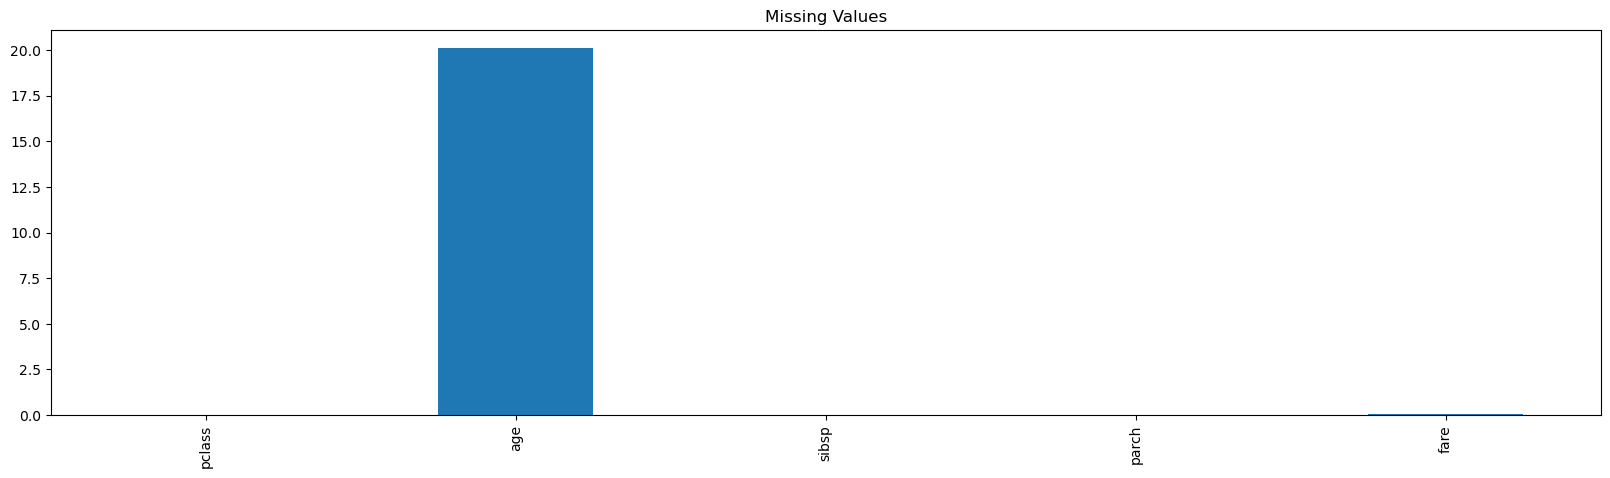

pclass      0
age       263
sibsp       0
parch       0
fare        1
dtype: int64


In [307]:
# first in numerical variables
# data[vars_num].isnull().value_counts()
num_miss= data[vars_num].isnull().sum()
num_miss_per = 100 * num_miss / len(data)
mis_val_table = pd.concat([num_miss, num_miss_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns['% of Total Values'].plot(figsize=(20,5),kind='bar', title='Missing Values')
plt.show()

print(num_miss)

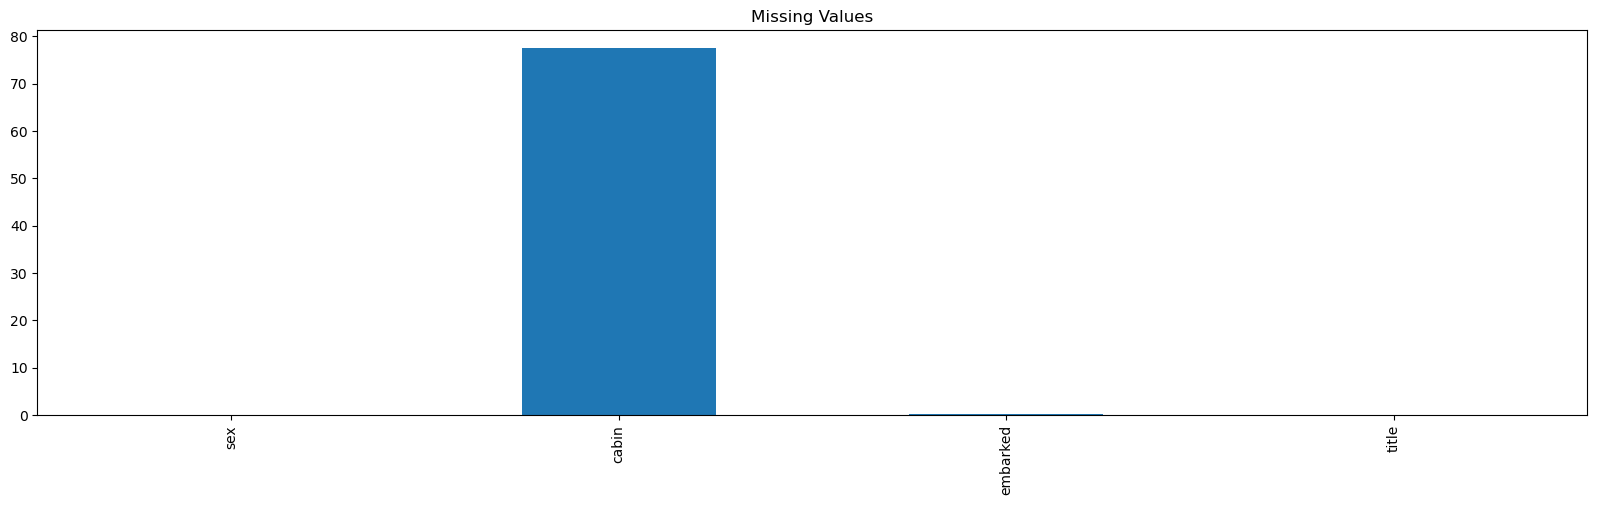

sex            0
cabin       1014
embarked       2
title          0
dtype: int64


In [308]:
# now in categorical variables
# data[vars_cat].isnull().value_counts()
cat_miss= data[vars_cat].isnull().sum()
cat_miss_per = 100 * cat_miss / len(data)
mis_val_table = pd.concat([cat_miss, cat_miss_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns['% of Total Values'].plot(figsize=(20,5),kind='bar', title='Missing Values')
plt.show()


print(cat_miss)

In [309]:
## function for displaying the distribution of a variable

def analyse_continuous(data, vars):
    for var in vars:
        print(var, ' contains ', len(data[var].unique()), ' labels')

    ## plot subplots for each category
    figure = plt.figure(figsize=(15, 15))
    for i, var in enumerate(vars):
        plt.subplot(3, 3, i+1)
        # data.groupby(var)[var].count().plot.bar()
        data[var].hist(bins=20)
        plt.title(var)
        plt.ylabel('Number of passengers')


### Determine cardinality of categorical variables

sex  contains  2  labels
cabin  contains  182  labels
embarked  contains  4  labels
title  contains  5  labels


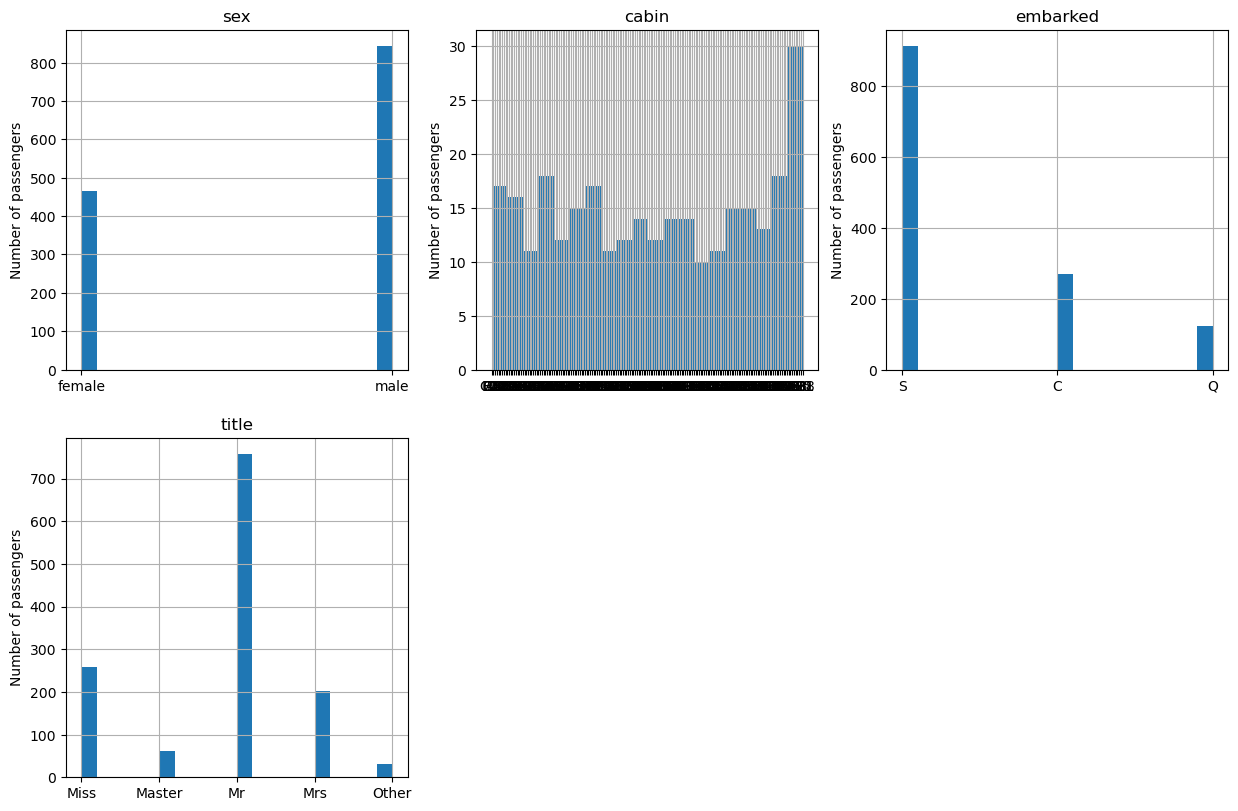

In [310]:
data[vars_cat].nunique()
analyse_continuous(data, vars_cat)

### Determine the distribution of numerical variables

pclass  contains  3  labels
age  contains  99  labels
sibsp  contains  7  labels
parch  contains  8  labels
fare  contains  282  labels


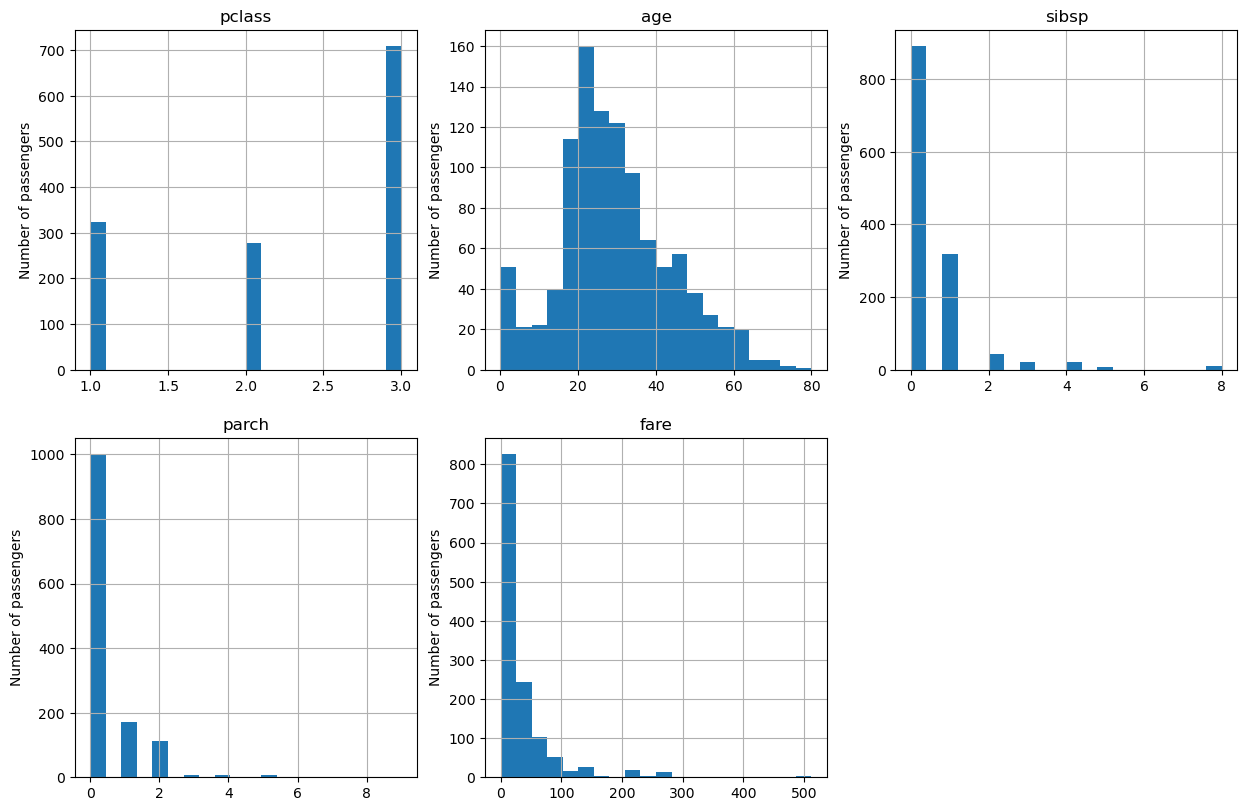

In [311]:
data[vars_num].nunique()

## plot the distribution of the numerical variables

analyse_continuous(data, vars_num)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [312]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [313]:
## print the unique values of 'cabin'
X_train['cabin'].unique()

array([nan, 'E40', 'F', 'A19', 'C32', 'D', 'B79', 'C62', 'E8', 'D28',
       'C45', 'C46', 'B22', 'B57', 'C23', 'E44', 'B45', 'B39', 'B58',
       'F2', 'C47', 'B101', 'D21', 'A7', 'E52', 'F38', 'E36', 'C68',
       'E24', 'C22', 'D38', 'B50', 'A24', 'C111', 'C6', 'C87', 'C93',
       'D36', 'C125', 'B35', 'T', 'B73', 'A26', 'A18', 'B96', 'G6', 'C78',
       'C101', 'D9', 'D33', 'C128', 'E50', 'B26', 'B69', 'E121', 'C123',
       'B94', 'A34', 'C39', 'D43', 'E31', 'B5', 'D17', 'F33', 'D7', 'A21',
       'D34', 'A29', 'D35', 'A11', 'B51', 'D46', 'E60', 'C30', 'D26',
       'E68', 'A9', 'B71', 'D37', 'C55', 'C89', 'C124', 'C126', 'E49',
       'E46', 'D19', 'C82', 'B52', 'C92', 'E45', 'C65', 'E25', 'B3',
       'D40', 'C91', 'B102', 'B61', 'A20', 'B36', 'C7', 'B77', 'D20',
       'C148', 'C105', 'E38', 'B86', 'C132', 'C86', 'A14', 'C54', 'A5',
       'B49', 'B28', 'B24', 'C2', 'F4', 'A6', 'C83', 'B42', 'A36', 'C52',
       'D56', 'C116', 'B19', 'E77', 'E101', 'B18', 'C95', 'D15', 'E33',


In [314]:
## extract the only the letter from the cabin variable
X_train['cabin'] = X_train['cabin'].str[0]
X_test['cabin'] = X_test['cabin'].str[0]

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [315]:
num_var_na = [var for var in vars_num if X_train[var].isnull().sum() > 0 ]
# print percentage of missing values per variable
X_train[num_var_na].isnull().mean()

## As we now age and fare have missing values, we will replace them with the median

age     0.196753
fare    0.000955
dtype: float64

In [316]:
# replace missing values as we described above
for var in num_var_na:

    # calculate the mean using the train set
    median_val = X_train[var].median()
    
    print(var, median_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)

# check that we have no more missing values in the engineered variables
X_train[num_var_na].isnull().sum()


age 28.0
fare 14.4542


age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [317]:
cat_var_na = [var for var in vars_cat if X_train[var].isnull().sum() > 0 ]
# print percentage of missing values per variable
X_train[cat_var_na].isnull().mean()

cabin       0.766953
embarked    0.001910
dtype: float64

In [318]:
# replace missing values with new label: "Missing"
X_train[cat_var_na] = X_train[cat_var_na].fillna('Missing')
X_test[cat_var_na] = X_test[cat_var_na].fillna('Missing')

# check that we have no more missing values in the engineered variables
print("X_train :")
print(X_train[cat_var_na].isnull().sum()) 
print("X_test :")
print(X_test[cat_var_na].isnull().sum()) 

X_train :
cabin       0
embarked    0
dtype: int64
X_test :
cabin       0
embarked    0
dtype: int64


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [319]:
X_train[vars_cat].nunique()

sex         2
cabin       9
embarked    4
title       5
dtype: int64

In [320]:
print ('% of each category in the variable')
for var in vars_cat:
    print(X_train[var].value_counts() / np.float(len(X_train)))
    print()

% of each category in the variable
male      0.633238
female    0.366762
Name: sex, dtype: float64

Missing    0.766953
C          0.074499
B          0.049666
E          0.034384
D          0.034384
A          0.018147
F          0.017192
G          0.003820
T          0.000955
Name: cabin, dtype: float64

S          0.709647
C          0.195798
Q          0.092646
Missing    0.001910
Name: embarked, dtype: float64

Mr        0.569245
Miss      0.200573
Mrs       0.159503
Master    0.044890
Other     0.025788
Name: title, dtype: float64



d:\Installation\miniconda3\envs\MLOps\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [321]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

sex Index(['female', 'male'], dtype='object', name='sex')

cabin Index(['C', 'Missing'], dtype='object', name='cabin')

embarked Index(['C', 'Q', 'S'], dtype='object', name='embarked')

title Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')



In [322]:
print("X_train :")
print(X_train[vars_cat].nunique())

X_train :
sex         2
cabin       3
embarked    4
title       4
dtype: int64


In [323]:
print("X_test :")
print(X_test[vars_cat].nunique())

X_test :
sex         2
cabin       3
embarked    3
title       4
dtype: int64


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [324]:
## one hot encoding of categorical variables

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train.shape, X_test.shape

((1047, 16), (262, 15))

In [325]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,1,1,0,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,1,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,1,0,1,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,1,0,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,1,0,0,0,1,1,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [326]:
## test does not have the embarked_Rare variable, so we add it
X_test['embarked_Rare'] = 0
col = X_train.columns
len(col)

16

In [327]:
## scale the variables

scaler = StandardScaler()

# fit the scaler to the train set
scaler.fit(X_train[col])

# transform the train and test set
X_train = scaler.transform(X_train[col])
X_test = scaler.transform(X_test[col])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [328]:
model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

ROC AUC: 0.61
Accuracy: 0.7022900763358778


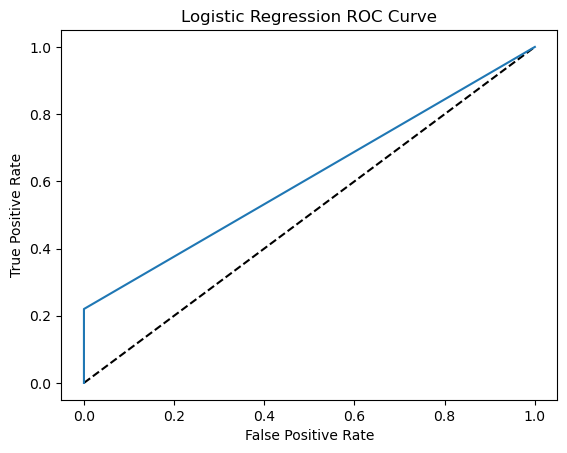

d:\Installation\miniconda3\envs\MLOps\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


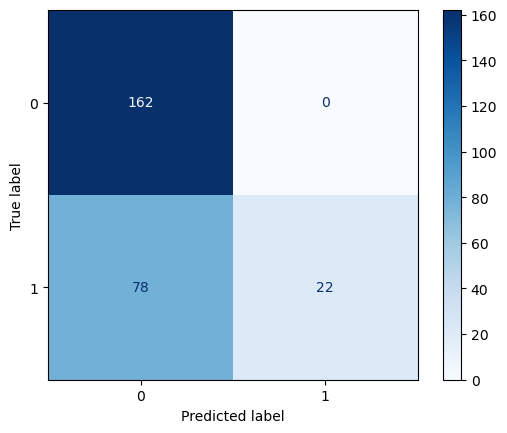

In [335]:
## make predictions and evaluate performance of the model ROC AUC and accuracy



y_pred = model.predict(X_test)

print('ROC AUC: {}'.format(roc_auc_score(y_test, y_pred)))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))


## plot the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()


## plot the confusion matrix

plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()




That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**